In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(url)

print(data.columns)


Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object')


In [4]:
X = data[['crim', 'rm']].values
y = data['medv'].values.reshape(-1, 1)

In [5]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X = (X - X_mean) / X_std


In [6]:
np.random.seed(42)
indices = np.random.permutation(len(X))

split = int(0.8 * len(X))
train_idx, test_idx = indices[:split], indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [7]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)


In [8]:
def initialize_parameters():
    params = {
        "W1": np.random.randn(2, 5) * 0.01,
        "b1": np.zeros((1, 5)),
        "W2": np.random.randn(5, 3) * 0.01,
        "b2": np.zeros((1, 3)),
        "W3": np.random.randn(3, 1) * 0.01,
        "b3": np.zeros((1, 1))
    }
    return params


In [9]:
def forward_propagation(X, params):
    Z1 = X @ params["W1"] + params["b1"]
    A1 = relu(Z1)

    Z2 = A1 @ params["W2"] + params["b2"]
    A2 = relu(Z2)

    Z3 = A2 @ params["W3"] + params["b3"]  # Linear output

    cache = (X, Z1, A1, Z2, A2, Z3)
    return Z3, cache


In [10]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


In [11]:
def backward_propagation(y, cache, params, l2_lambda=0):
    X, Z1, A1, Z2, A2, Z3 = cache
    m = len(X)

    dZ3 = (Z3 - y) / m
    dW3 = A2.T @ dZ3 + l2_lambda * params["W3"]
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = dZ3 @ params["W3"].T
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = A1.T @ dZ2 + l2_lambda * params["W2"]
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ params["W2"].T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X.T @ dZ1 + l2_lambda * params["W1"]
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    grads = {"dW1": dW1, "db1": db1,
             "dW2": dW2, "db2": db2,
             "dW3": dW3, "db3": db3}
    return grads


In [12]:
def update_gd(params, grads, lr):
    for i in range(1, 4):
        params[f"W{i}"] -= lr * grads[f"dW{i}"]
        params[f"b{i}"] -= lr * grads[f"db{i}"]


In [13]:
def initialize_velocity(params):
    v = {}
    for key in params:
        v[key] = np.zeros_like(params[key])
    return v

def update_momentum(params, grads, v, lr, beta=0.9):
    for i in range(1, 4):
        v[f"W{i}"] = beta * v[f"W{i}"] + (1 - beta) * grads[f"dW{i}"]
        v[f"b{i}"] = beta * v[f"b{i}"] + (1 - beta) * grads[f"db{i}"]

        params[f"W{i}"] -= lr * v[f"W{i}"]
        params[f"b{i}"] -= lr * v[f"b{i}"]


In [14]:
def initialize_adam(params):
    v, s = {}, {}
    for key in params:
        v[key] = np.zeros_like(params[key])
        s[key] = np.zeros_like(params[key])
    return v, s

def update_adam(params, grads, v, s, t, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
    for i in range(1, 4):
        for param in ["W", "b"]:
            key = f"{param}{i}"
            grad = grads[f"d{key}"]

            v[key] = beta1 * v[key] + (1 - beta1) * grad
            s[key] = beta2 * s[key] + (1 - beta2) * (grad ** 2)

            v_corr = v[key] / (1 - beta1 ** t)
            s_corr = s[key] / (1 - beta2 ** t)

            params[key] -= lr * v_corr / (np.sqrt(s_corr) + eps)


In [15]:
def train(X, y, optimizer="gd", lr=0.01, epochs=1000, l2_lambda=0):
    params = initialize_parameters()
    losses = []

    if optimizer == "momentum":
        v = initialize_velocity(params)
    if optimizer == "adam":
        v, s = initialize_adam(params)

    for epoch in range(1, epochs + 1):
        y_pred, cache = forward_propagation(X, params)
        loss = mse_loss(y, y_pred)
        losses.append(loss)

        grads = backward_propagation(y, cache, params, l2_lambda)

        if optimizer == "gd":
            update_gd(params, grads, lr)
        elif optimizer == "momentum":
            update_momentum(params, grads, v, lr)
        elif optimizer == "adam":
            update_adam(params, grads, v, s, epoch, lr)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return params, losses


In [16]:
params, losses = train(X_train, y_train, optimizer="adam", lr=0.01)


Epoch 100, Loss: 51.2774
Epoch 200, Loss: 28.5928
Epoch 300, Loss: 27.5698
Epoch 400, Loss: 27.3985
Epoch 500, Loss: 27.3358
Epoch 600, Loss: 27.2719
Epoch 700, Loss: 27.1732
Epoch 800, Loss: 27.0817
Epoch 900, Loss: 26.8676
Epoch 1000, Loss: 26.6822


In [17]:
y_test_pred, _ = forward_propagation(X_test, params)
test_mse = mse_loss(y_test, y_test_pred)

print("Test MSE:", test_mse)


Test MSE: 28.352766919911208


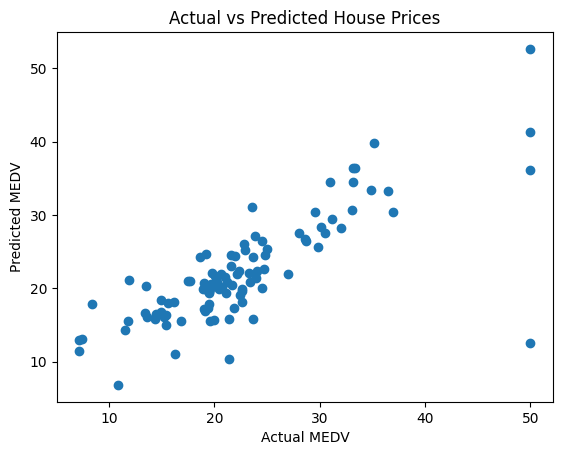

In [18]:
plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted House Prices")
plt.show()
